<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Shot_Target_Prediction_Model_%2B_Simulation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


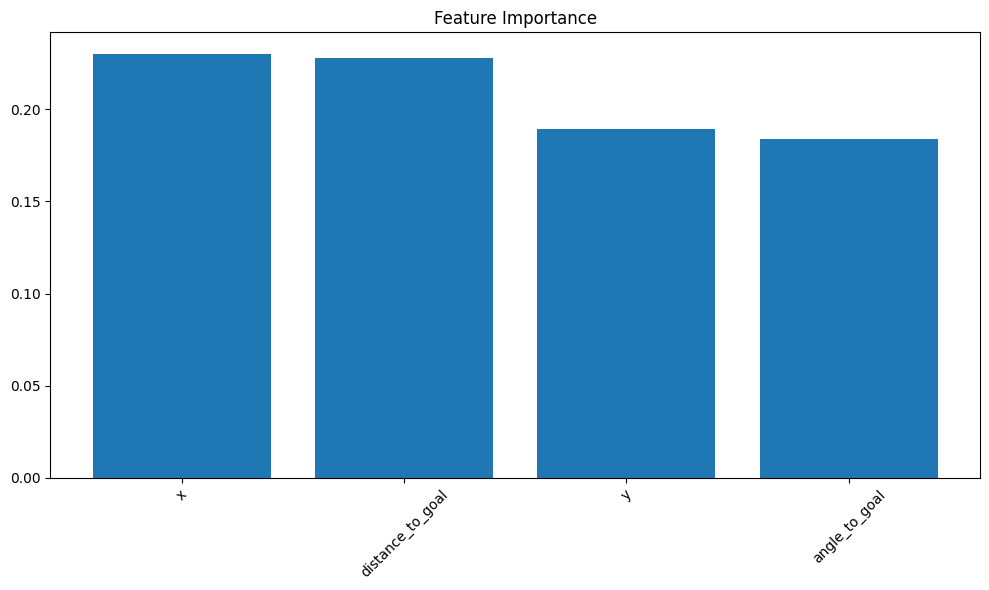

Classification Report:
               precision    recall  f1-score   support

bottom_center       0.00      0.00      0.00         1
middle_center       1.00      1.00      1.00         1
  middle_left       0.00      0.00      0.00         0
   top_center       0.00      0.00      0.00         0
     top_left       0.00      0.00      0.00         1

     accuracy                           0.33         3
    macro avg       0.20      0.20      0.20         3
 weighted avg       0.33      0.33      0.33         3

✅ Results saved to: /content/drive/MyDrive/Recruitment/shot_prediction_results.xlsx


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# STEP 1: MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: LOAD CSV FILE
import pandas as pd
import numpy as np
import math

file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'  # Update if needed
df = pd.read_csv(file_path)

# STEP 2.5: Standardize playerName column
if 'playerName' not in df.columns:
    possible_names = [col for col in df.columns if 'player' in col.lower() and 'name' in col.lower()]
    if possible_names:
        df.rename(columns={possible_names[0]: 'playerName'}, inplace=True)

# STEP 3: FILTER SHOTS
shot_types = [13, 14, 15, 16]
shots = df[df['typeId'].isin(shot_types)].copy()
shots['playerName'] = shots['playerName'].fillna('Unknown')

# STEP 4: FEATURE ENGINEERING
def calc_distance(x, y, goal_x=100, goal_y=50):
    return np.sqrt((goal_x - x)**2 + (goal_y - y)**2)

def calc_angle(x, y, goal_width=7.32):
    goal_y1 = 50 - (goal_width / 2)
    goal_y2 = 50 + (goal_width / 2)
    a = np.sqrt((100 - x)**2 + (y - goal_y1)**2)
    b = np.sqrt((100 - x)**2 + (y - goal_y2)**2)
    c = goal_width
    try:
        return math.acos((a**2 + b**2 - c**2) / (2 * a * b))
    except:
        return 0

shots['distance_to_goal'] = shots.apply(lambda row: calc_distance(row['x'], row['y']), axis=1)
shots['angle_to_goal'] = shots.apply(lambda row: calc_angle(row['x'], row['y']), axis=1)
shots['shot_type'] = shots['typeId'].map({13: 'off_target', 14: 'post', 15: 'on_target', 16: 'goal'})

# STEP 5: SIMULATE GOALMOUTH ZONES
def simulate_goalmouth_zone(x, y):
    if np.isnan(x) or np.isnan(y):
        return "unknown"
    y_noisy = y + np.random.normal(0, 5)
    if y_noisy < 30:
        horiz = "left"
    elif y_noisy > 70:
        horiz = "right"
    else:
        horiz = "center"
    r = np.random.rand()
    if r < 0.3:
        vert = "top"
    elif r < 0.6:
        vert = "bottom"
    else:
        vert = "middle"
    return f"{vert}_{horiz}"

shots['goalmouth_zone'] = shots.apply(lambda row: simulate_goalmouth_zone(row['x'], row['y']), axis=1)

# STEP 6: ENCODE FEATURES
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

shots = shots.dropna(subset=['distance_to_goal', 'angle_to_goal', 'goalmouth_zone'])
le_zone = LabelEncoder()
shots['zone_encoded'] = le_zone.fit_transform(shots['goalmouth_zone'])

# Encode playerName as one-hot (use sparse_output for compatibility)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
player_encoded = ohe.fit_transform(shots[['playerName']])
player_feature_names = ohe.get_feature_names_out(['playerName'])

# Combine numerical and player features
features = ['x', 'y', 'distance_to_goal', 'angle_to_goal']
X_base = shots[features].reset_index(drop=True)
X = pd.concat([X_base, pd.DataFrame(player_encoded, columns=player_feature_names)], axis=1)
y = shots['zone_encoded']

# STEP 7: TRAIN MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# STEP 8: FEATURE IMPORTANCE VISUALIZATION
import matplotlib.pyplot as plt

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(features)), importances[indices][:len(features)])
plt.xticks(range(len(features)), feature_names[:len(features)], rotation=45)
plt.tight_layout()
plt.show()

# STEP 9: PRINT RESULTS
present_labels = unique_labels(y_test, y_pred)
present_class_names = le_zone.inverse_transform(present_labels)

print("Classification Report:")
print(classification_report(y_test, y_pred, labels=present_labels, target_names=present_class_names))

# STEP 10: EXPORT RESULTS TO EXCEL IN GOOGLE DRIVE
results_df = shots[['playerName', 'x', 'y', 'distance_to_goal', 'angle_to_goal', 'goalmouth_zone']]
excel_path = '/content/drive/MyDrive/Recruitment/shot_prediction_results.xlsx'
results_df.to_excel(excel_path, index=False)
print(f"✅ Results saved to: {excel_path}")


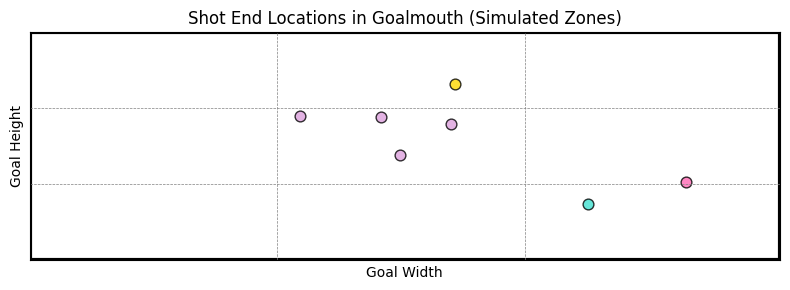

In [ ]:
# STEP 11: VISUALIZE SHOTS IN GOALMOUTH ZONES

# Filter for visualizable shots (goals, on target, post)
goalmouth_shots = shots[shots['typeId'].isin([14, 15, 16])].copy()

# Define 3x3 zone layout with starting positions (width = 100, height = 33)
zone_coords = {
    'top_left': (0, 22), 'top_center': (33, 22), 'top_right': (66, 22),
    'middle_left': (0, 11), 'middle_center': (33, 11), 'middle_right': (66, 11),
    'bottom_left': (0, 0), 'bottom_center': (33, 0), 'bottom_right': (66, 0)
}

zone_colors = {
    "top_left": "#FF6347", "top_center": "#FFD700", "top_right": "#ADFF2F",
    "middle_left": "#87CEFA", "middle_center": "#DDA0DD", "middle_right": "#FF69B4",
    "bottom_left": "#00FA9A", "bottom_center": "#FFA500", "bottom_right": "#40E0D0",
    "unknown": "#D3D3D3"
}

# Create the goal plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0, 100)
ax.set_ylim(0, 33)
ax.set_title("Shot End Locations in Goalmouth (Simulated Zones)")
ax.set_xlabel("Goal Width")
ax.set_ylabel("Goal Height")
ax.set_xticks([])
ax.set_yticks([])

# Draw the goal frame
ax.plot([0, 100], [0, 0], color='black', linewidth=3)
ax.plot([0, 0], [0, 33], color='black', linewidth=3)
ax.plot([100, 100], [0, 33], color='black', linewidth=3)
ax.plot([0, 100], [33, 33], color='black', linewidth=3)

# Draw grid lines
for x in [33, 66]:
    ax.plot([x, x], [0, 33], color='gray', linestyle='--', linewidth=0.5)
for y in [11, 22]:
    ax.plot([0, 100], [y, y], color='gray', linestyle='--', linewidth=0.5)

# Plot each shot
for _, row in goalmouth_shots.iterrows():
    zone = row['goalmouth_zone']
    base_x, base_y = zone_coords.get(zone, (45, 16))
    x = base_x + np.random.uniform(0, 33)
    y = base_y + np.random.uniform(0, 11)
    color = zone_colors.get(zone, '#D3D3D3')
    ax.scatter(x, y, color=color, edgecolors='black', s=60, alpha=0.8)

plt.tight_layout()
plt.show()


           Strategy  Avg Success Probability
1    Bottom Corners                 0.857778
3  All Bottom Zones                 0.428078
5   Random Any Zone                 0.202500
4      Middle Zones                 0.041422
0       Top Corners                 0.000000
2     All Top Zones                 0.000000


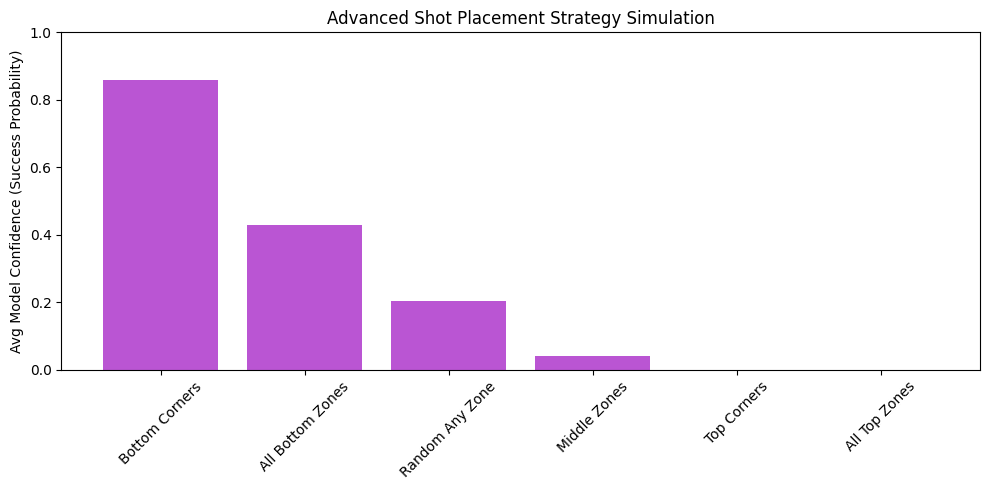

In [ ]:
# STEP 13: ADVANCED STRATEGY SIMULATION (Proba-based, per player, zone-safe)

import random
from collections import defaultdict

# 1. ✅ Only use zones the model has seen
available_zones = set(le_zone.classes_)

# 2. 🔧 Define possible strategies (full set)
all_strategies = {
    "Top Corners": ["top_left", "top_right"],
    "Bottom Corners": ["bottom_left", "bottom_right"],
    "All Top Zones": ["top_left", "top_center", "top_right"],
    "All Bottom Zones": ["bottom_left", "bottom_center", "bottom_right"],
    "Middle Zones": ["middle_left", "middle_center", "middle_right"],
    "Random Any Zone": list(le_zone.classes_)
}

# 3. 🛡️ Filter strategies to remove unknown zones
strategies = {
    name: [z for z in zones if z in available_zones]
    for name, zones in all_strategies.items()
}
strategies = {k: v for k, v in strategies.items() if v}

# 4. 📦 Simulate for each player using their actual encoded vector
n_shots = 200
players = shots['playerName'].unique()

# Prepare player vectors from encoded DataFrame
player_ohe_df = pd.DataFrame(player_encoded, columns=player_feature_names)
player_ohe_df['playerName'] = shots['playerName'].reset_index(drop=True)

player_vectors = {
    name: group.iloc[0].drop('playerName').values
    for name, group in player_ohe_df.groupby('playerName')
}

# 5. 🧠 Simulate strategy performance
sim_results = []

for strategy_name, target_zones in strategies.items():
    total_confidence = 0
    shot_count = 0

    for player in players:
        if player not in player_vectors:
            continue

        player_vec = player_vectors[player]

        for _ in range(n_shots):
            target_zone = random.choice(target_zones)
            try:
                target_zone_index = le_zone.transform([target_zone])[0]
            except:
                continue  # skip if label is not known to model

            # Simulated input = average shot features + player vector
            sim_features = X_base.mean().to_dict()
            sim_input = pd.DataFrame([sim_features])
            sim_player = pd.DataFrame([player_vec], columns=player_feature_names)
            sim_X = pd.concat([sim_input, sim_player], axis=1)

            # Predict probability for this target zone
            zone_probs = clf.predict_proba(sim_X)[0]
            if target_zone_index >= len(zone_probs):
                continue  # skip out-of-bounds

            confidence = zone_probs[target_zone_index]
            total_confidence += confidence
            shot_count += 1

    avg_success_prob = total_confidence / shot_count if shot_count > 0 else 0
    sim_results.append((strategy_name, avg_success_prob))

# 6. 📊 Results and Visualization
adv_sim_df = pd.DataFrame(sim_results, columns=["Strategy", "Avg Success Probability"])
adv_sim_df = adv_sim_df.sort_values(by="Avg Success Probability", ascending=False)
print(adv_sim_df)

# 7. 📈 Plot results
plt.figure(figsize=(10, 5))
plt.bar(adv_sim_df["Strategy"], adv_sim_df["Avg Success Probability"], color='mediumorchid')
plt.ylabel("Avg Model Confidence (Success Probability)")
plt.title("Advanced Shot Placement Strategy Simulation")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
# STEP 14: TRAIN MODEL TO PREDICT SHOT OUTCOME (goal, post, etc.)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Prepare outcome label
outcome_le = LabelEncoder()
shots['outcome_label'] = outcome_le.fit_transform(shots['shot_type'])  # from earlier step

# Prepare features
X_outcome = pd.concat([X_base.reset_index(drop=True), pd.DataFrame(player_encoded, columns=player_feature_names)], axis=1)
y_outcome = shots['outcome_label']

# Train the model
clf_outcome = RandomForestClassifier(n_estimators=100, random_state=42)
clf_outcome.fit(X_outcome, y_outcome)

# Check outcome classes (for later decoding)
print("Outcome classes:", list(outcome_le.classes_))
# STEP 15: FULL SIMULATION (ZONES + OUTCOME + PLAYER-WISE + EXPORT)

import random
import pandas as pd

strategies = {
    "Top Corners": ["top_left", "top_right"],
    "Bottom Corners": ["bottom_left", "bottom_right"],
    "All Top Zones": ["top_left", "top_center", "top_right"],
    "All Bottom Zones": ["bottom_left", "bottom_center", "bottom_right"],
    "Middle Zones": ["middle_left", "middle_center", "middle_right"],
    "Random Any Zone": list(le_zone.classes_)
}

# Clean up invalid strategies
available_zones = set(le_zone.classes_)
strategies = {
    name: [z for z in zones if z in available_zones]
    for name, zones in strategies.items()
}
strategies = {k: v for k, v in strategies.items() if v}

n_shots = 100
players = shots['playerName'].unique()

player_ohe_df = pd.DataFrame(player_encoded, columns=player_feature_names)
player_ohe_df['playerName'] = shots['playerName'].reset_index(drop=True)

player_vectors = {
    name: group.iloc[0].drop('playerName').values
    for name, group in player_ohe_df.groupby('playerName')
}

# Store all results
all_sim_rows = []

for player in players:
    if player not in player_vectors:
        continue

    player_vec = player_vectors[player]

    for strategy_name, target_zones in strategies.items():
        total_confidence = 0
        goal_count = 0
        outcome_counts = {o: 0 for o in outcome_le.classes_}

        for _ in range(n_shots):
            target_zone = random.choice(target_zones)
            try:
                target_zone_index = le_zone.transform([target_zone])[0]
            except:
                continue

            base_features = X_base.mean().to_dict()
            sim_input = pd.DataFrame([base_features])
            sim_player = pd.DataFrame([player_vec], columns=player_feature_names)
            sim_X = pd.concat([sim_input, sim_player], axis=1)

            # Zone prediction confidence
            zone_probs = clf.predict_proba(sim_X)[0]
            if target_zone_index >= len(zone_probs):
                continue
            confidence = zone_probs[target_zone_index]
            total_confidence += confidence

            # Predict shot outcome
            outcome_pred = clf_outcome.predict(sim_X)[0]
            outcome_label = outcome_le.inverse_transform([outcome_pred])[0]
            outcome_counts[outcome_label] += 1

            if outcome_label == 'goal':
                goal_count += 1

        avg_conf = total_confidence / n_shots
        goal_rate = goal_count / n_shots

        sim_row = {
            "playerName": player,
            "strategy": strategy_name,
            "avg_zone_confidence": avg_conf,
            "goal_rate": goal_rate,
        }
        sim_row.update(outcome_counts)
        all_sim_rows.append(sim_row)

# Final results
full_sim_df = pd.DataFrame(all_sim_rows)
summary_df = full_sim_df.groupby("strategy")[["avg_zone_confidence", "goal_rate"] + list(outcome_le.classes_)].mean().reset_index()

# Export to Excel
from pathlib import Path
excel_path = "/content/drive/MyDrive/Recruitment/full_shot_strategy_simulation.xlsx"
with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    full_sim_df.to_excel(writer, sheet_name="Player_Strategy_Detail", index=False)
    summary_df.to_excel(writer, sheet_name="Strategy_Summary", index=False)

print(f"✅ Simulation results saved to: {excel_path}")


Outcome classes: ['goal', 'off_target', 'on_target']
✅ Simulation results saved to: /content/drive/MyDrive/Recruitment/full_shot_strategy_simulation.xlsx


<ipython-input-17-df2a7d3844c9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df.sort_values('goal_rate', ascending=False), x='goal_rate', y='strategy', palette="Blues_d")


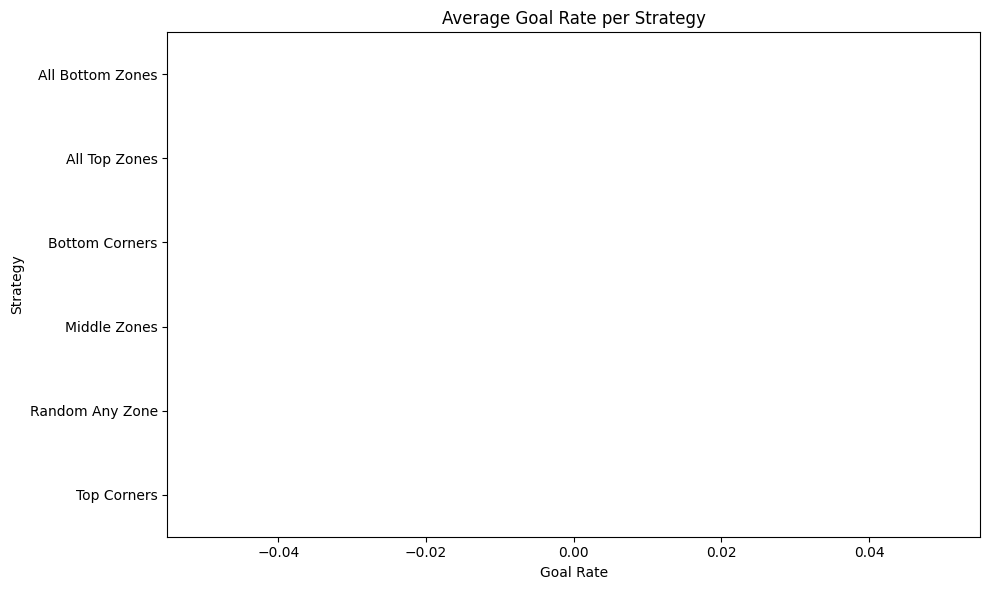

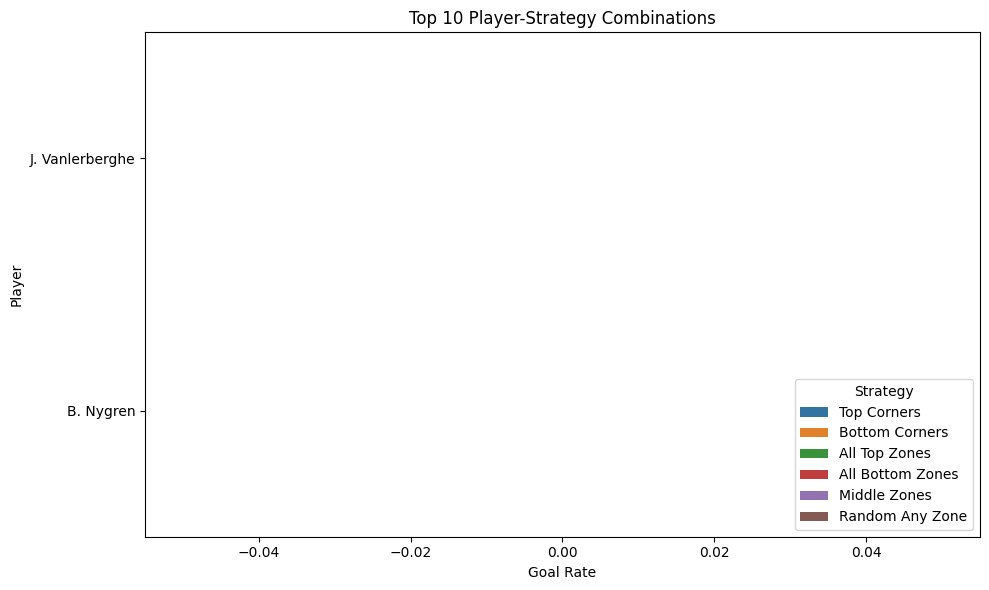

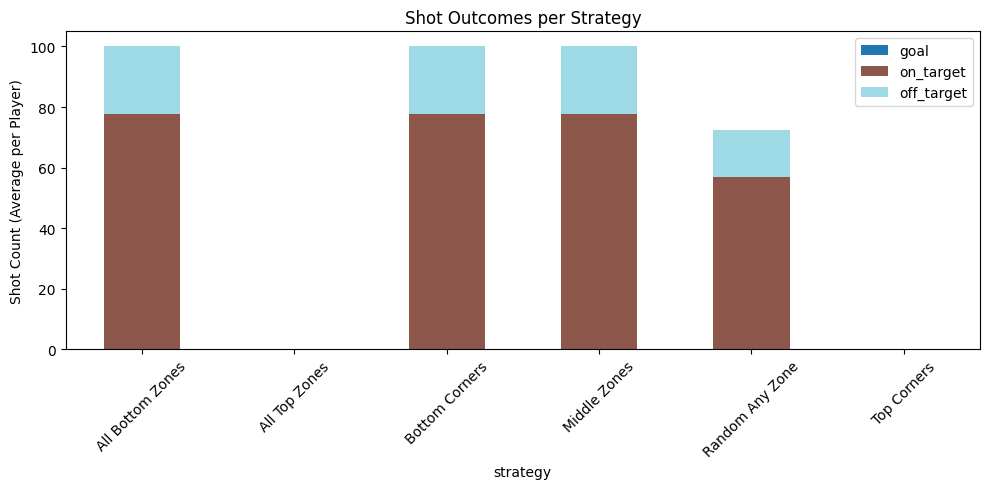

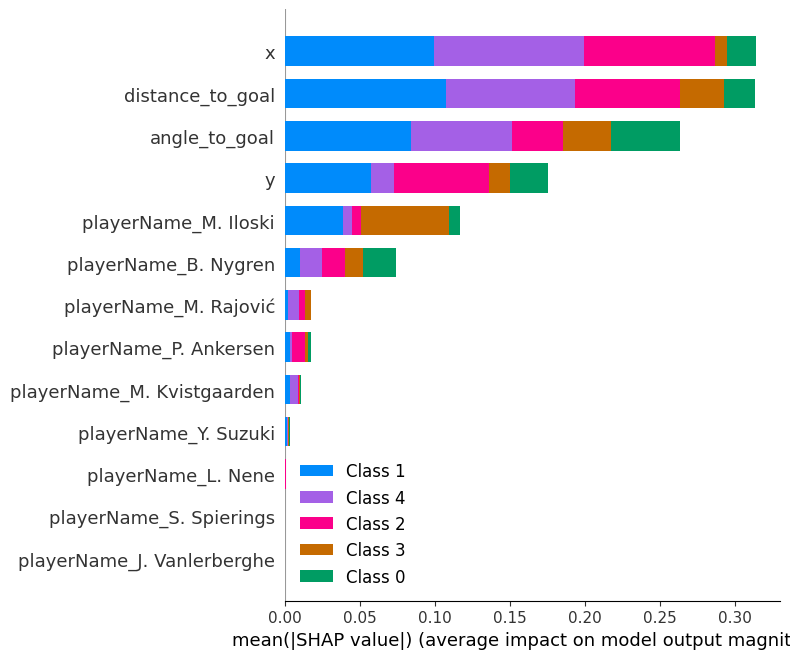

In [ ]:
# STEP 16: VISUAL DASHBOARDS AND SHAP ANALYSIS

import seaborn as sns
import matplotlib.pyplot as plt
import shap

# 1. 📊 STRATEGY GOAL RATE OVERALL
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df.sort_values('goal_rate', ascending=False), x='goal_rate', y='strategy', palette="Blues_d")
plt.title("Average Goal Rate per Strategy")
plt.xlabel("Goal Rate")
plt.ylabel("Strategy")
plt.tight_layout()
plt.show()

# 2. 📊 TOP PLAYER-STRATEGY COMBOS
top_players = full_sim_df.sort_values('goal_rate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_players, x='goal_rate', y='playerName', hue='strategy', dodge=False)
plt.title("Top 10 Player-Strategy Combinations")
plt.xlabel("Goal Rate")
plt.ylabel("Player")
plt.legend(title="Strategy", loc="lower right")
plt.tight_layout()
plt.show()

# 3. 📊 SHOT OUTCOME STACKED BAR (SAFE)
outcome_cols = [col for col in ['goal', 'post', 'on_target', 'off_target'] if col in summary_df.columns]

if outcome_cols:
    df_outcome = summary_df.set_index("strategy")[outcome_cols]
    df_outcome.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='tab20')
    plt.title("Shot Outcomes per Strategy")
    plt.ylabel("Shot Count (Average per Player)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No shot outcome columns found for plotting.")

# 4. 🧠 SHAP EXPLANATION FOR ZONE MODEL
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

# SHAP bar summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Optional: waterfall plot for 1 prediction
# shap.plots.waterfall(shap_values[0])

# 5. 🧑 PLAYER PROFILE DASHBOARD
def plot_player_profile(player_name):
    df_player = full_sim_df[full_sim_df['playerName'] == player_name].copy()
    if df_player.empty:
        print(f"No data for {player_name}")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_player.sort_values('goal_rate', ascending=False), x='goal_rate', y='strategy', palette='viridis')
    plt.title(f"Goal Rate by Strategy – {player_name}")
    plt.xlabel("Goal Rate")
    plt.ylabel("Strategy")
    plt.tight_layout()
    plt.show()

# Example usage
# plot_player_profile("Your Player Name")


In [ ]:
!pip install matplotlib pandas fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=d8ce1681c2c69dab022ba4507aa4b470e6133a80b53e1bbde3402ead365cbe70
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
